In [0]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [0]:
def loadImage(file_name, image_format):
  image = cv.imread(file_name, image_format)
  return image

We will try to estimate local means and local variances for the image for a local region $n$ by $m$.

To estimate the final matrix we use the following formula to estimate the means and the variances.

$$\mu = \displaystyle\frac{1}{nm}\displaystyle\sum_{i,j \in N} X(i, j)$$

$$\sigma^2 = \displaystyle\frac{1}{nm}\displaystyle\sum_{i,j \in N} X^2(i, j) - \mu^2$$

For an $n$ by $m$ local neighbourhood around every pixel in input image X.

Then finally we estimate Y, the new signal image,

$$Y(i, j) = \mu + \displaystyle\frac{\max(0,\sigma^2 - n_v^2)}{\max(\sigma^2, n_v^2)} \displaystyle (X(i,j) - \mu)$$

where $n_v$ is the noise variance and it is estimated from the reduced sums of
the projections (rows, columns) along the variance matrix.


In [0]:
class WienerFilter():
  def __init__(self, input, filter_size):
    self.input = input
    self.filter_size = filter_size
    if(input.ndim != 2):
      print("Image not 2d")
    if(filter_size[0]%2 != 1 or filter_size[1]%2 != 1 or filter_size[0]<=1 or filter_size[1]<=1):
      print("Invalid filter dimension")

  def estimateOutput(self):
    means = cv.boxFilter(src=self.input, ddepth=cv.CV_64F, ksize=tuple(self.filter_size), anchor=(-1,1), normalize=True, borderType=cv.BORDER_REPLICATE)
    square_means = cv.sqrBoxFilter(src=self.input, ddepth=cv.CV_64F, ksize=tuple(self.filter_size), anchor=(-1,1), normalize=True, borderType=cv.BORDER_REPLICATE)
    
    means2 = cv.multiply(means, means)

    #calculating the variance matrix 
    variances = square_means - means2

    # estimating noise variance by finding projections across length and width
    avgVarianceMat = cv.reduce(variances, 1, cv.REDUCE_SUM, -1)
    avgVarianceMat = cv.reduce(avgVarianceMat, 0, cv.REDUCE_SUM, -1)

    noiseVar = np.asscalar(avgVarianceMat/self.input.shape[0] * self.input.shape[1])
    
    y = np.zeros(self.input.shape)
    for row in range(self.input.shape[0]):
      for col in range(self.input.shape[1]):
        y[row][col] = means[row][col] + max(0, variances[row][col] - noiseVar) * (self.input[row][col]-means[row][col])/max(variances[row][col], noiseVar)

    return y
  
  def estimateOutputColorised(self):
    # get all local means in 
    means = cv.boxFilter(src=self.input, ddepth=cv.CV_64F, ksize=tuple(self.filter_size), anchor=(-1,1), normalize=True, borderType=cv.BORDER_REPLICATE)
    square_means = cv.sqrBoxFilter(src=self.input, ddepth=cv.CV_64F, ksize=tuple(self.filter_size), anchor=(-1,1), normalize=True, borderType=cv.BORDER_REPLICATE)
    
    means2 = cv.multiply(means, means)
    variances = square_means - means2

    avgVariance = cv.reduce(variances, 0, cv.REDUCE_SUM, -1)
    avgVariance = cv.reduce(avgVariance, 1, cv.REDUCE_SUM, -1)

    noiseVar = avgVariance/self.input.shape[0] * self.input.shape[1] * self.input.shape[2]

    noiseVar = np.reshape(noiseVar, (1,3))
    
    y = np.zeros(self.input.shape)
    
    for row in range(self.input.shape[0]):
      for col in range(self.input.shape[1]):
          y[row][col] = self.saturate_cast(means[row][col] + np.maximum(np.zeros(noiseVar[0].shape), variances[row][col] - noiseVar[0]) * (self.input[row][col]-means[row][col])/np.maximum(variances[row][col], noiseVar[0]))

    return y
  
  def saturate_cast(self, val):
    
    if val.any() < 0:
      return np.array([255, 255, 255])
    elif val.any() >255:
      return np.array([255,255, 255])
    return val



In [0]:
def plot(images, options):
  f, (a0, a1, a2) = plt.subplots(1, 3)
  f.set_figwidth(15)
  f.set_figheight(15)
  a0.set_title('Original')
  a1.set_title('Wiener Filter')
  a2.set_title('Sharpened Image from Wiener Filter')
  a0.imshow(images[0], options)
  a1.imshow(images[1], options)
  a2.imshow(images[2], options)



Example 1 - RGB Denoising

Image not 2d


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


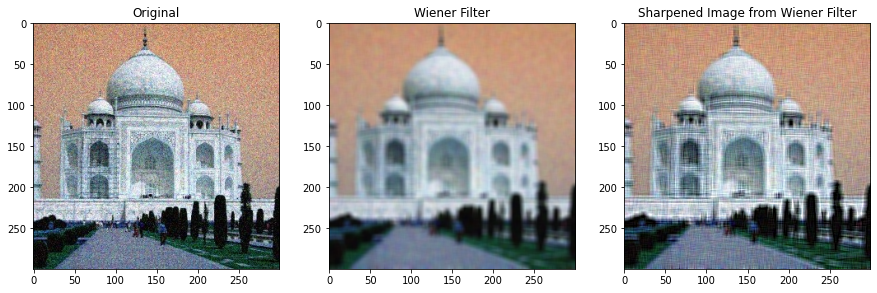

In [7]:
image_ex_3 = loadImage('rgb_noise.jpg',1)
wiener_ex_3 = WienerFilter(image_ex_3, (7,7))
output_ex_3 = wiener_ex_3.estimateOutputColorised()

sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpen = cv.filter2D(output_ex_3, -1, sharpen_kernel)

images = [image_ex_3, np.array(output_ex_3,np.int32), np.array(sharpen,np.int32)]

plot(images, options=None)


Example 2 - BW Denoising and Sharpness Enhancement

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


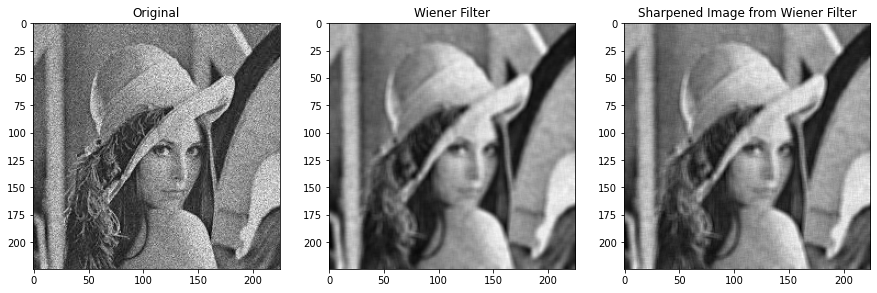

In [8]:
image_ex_2 = loadImage('high_noise.jpeg',0)
wiener_ex_2 = WienerFilter(image_ex_2, (5,5))
output_ex_2 = wiener_ex_2.estimateOutput()

sharpen_kernel = np.array([[0,-1,0], [-1,7,-1], [0,-1,0]])
sharpen = cv.filter2D(output_ex_2, -1, sharpen_kernel)

images = [image_ex_2, output_ex_2, sharpen]
plot(images, options='gray')


Example 3 - BW Denoising and Sharpness Enhancement

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


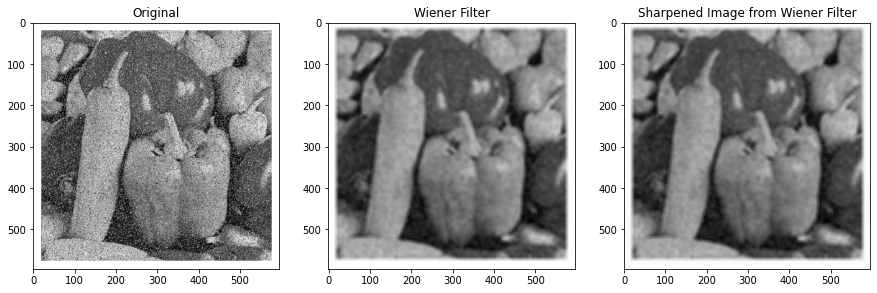

In [434]:
image_ex_3 = loadImage('blur.jpg',0)
wiener_ex_3 = WienerFilter(image_ex_3, (11,11))
output_ex_3 = wiener_ex_3.estimateOutput()

sharpen_kernel = np.array([[0,-1,0], [-1,9,-1], [0,-1,0]])
sharpen = cv.filter2D(output_ex_3, -1, sharpen_kernel)

images = [image_ex_3, output_ex_3, sharpen]
plot(images, options='gray')